This code produces all figures as well as summary statistics reported in the main paper and supplement. It has to be run after the analysis code `OIC-OO v6` and the results processing code `OSM Results Processing`, using the same ControlFile and from the same folder; this code will read the processed .tab files from the analysis, and will fail if they are not available. See main `Analysis Code` folder for `ReadMe` with explanation of ControlFile format and fields.

In [1]:
import os
import json
import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.cm as cm

from shutil import copy
from distutils.dir_util import copy_tree


def get_value(file, varname):
    """General purpose function for reading values from .mdl, .out, etc. 
    files; returns value matching `varname` in a 'var = val' syntax"""
    varregex = regex.compile(r'(?<=([^\w ]|\n)\s?' + regex.escape(varname)
                             + r'\s*=)\s*-?(?:\d*)(\.\d*)?([eE][+\-]?\d+)?')

    with open(file, 'r') as f:
        filetext = f.read()
        value = float((regex.search(varregex, filetext))[0])

    return value


def strbds_from_perc(perc):
    """Return lower & upper bounds that define `perc` CrI as strings"""
    if perc > 1: # If perc specified as percentage (not decimal)
        return [str(round((0.5 - perc/200), 3)), str(round((0.5 + perc/200), 3))]
    else: # If perc specified as decimal, not 100%
        return [str(round((0.5 - perc/2), 3)), str(round((0.5 + perc/2), 3))]

In [3]:
# Read specified controlfile and unpack into variables
controlfilename = input("Enter control file name (with extension):")
cf = json.load(open(controlfilename, 'r'))

for k,v in cf.items():
    exec(k + '=v')

for setting in [analysissettings]:
    for k, v in setting.items():
        exec(k + '=v')

# Initialise base working directory
os.chdir(f"{baserunname}_IterCal")
basedir = os.getcwd()
os.chdir('./Results')

Enter control file name (with extension): OICC0607.txt


In [4]:
##### PLOT MAIN FITS, PROJECTIONS, AND CALCULATE GOF STATISTICS #####

def plot_fits_main(fits, mainfits, fitdict, ylabels, errmult=1.96):
    """Plot fit-to-data for six variables specified in `mainfits` list, 
    with names and y-labels from `fitdict` and `ylabels`, and error bars 
    where available of `errmult` x stderr"""
    
    # Define main figure and axes
    fig0, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(
        3, 2, figsize=[12, 12], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax1, ax2, ax3, ax4, ax5]

    # Plot sim output, data, and error bars where available
    for ax, var in zip(ax_list, mainfits):
        ax.plot(fits.columns, fits.loc[f'SimVar[{var}]'], lw=2, zorder=10, label='Simulated')
        ax.scatter(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
                   color='silver', label='Historical')
        try:
            ax.errorbar(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
                        yerr=fits.loc[f'DataErr[{var}]'][::4] * errmult, fmt='o', 
                        color='silver', capsize=3, label='Historical') # Use errmult=1.96 for 95%CI
        except KeyError: # Catch exception when DataErr not available
            pass
        ax.set_title(fitdict[var])
        
        ax.set_ylim(0) # Anchor y axis on 0
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

    # Format X and Y axis for bottom two axes
    for ax in [ax4, ax5]:
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8, labelrotation=90)
        
        # Override Y-axis scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    
    # Set labels for left-hand axes only, and figure title
    for ax, label in zip([ax0, ax2, ax4], ylabels):
        ax.set_ylabel(label)
    fig0.suptitle('Model fit to data for selected variables', fontsize=14)
    
    fig0.savefig(f"./{baserunname}_fits_main.jpg", bbox_inches='tight')


def plot_fits_proj_scens(baserunname, scens, projfits, fitdict, bounds, 
                         ylabels, basevar='SimVar', endyear='2019'):
    """Plot projections across multiple scenarios from `scens` for six 
    vars specified in `projfits` list, with CrIs specified in `bounds` 
    (multiple CrIs allowed, use paired lower/upper values) and names and 
    y-labels from `fitdict` and `ylabels`; uses SimVar by default but 
    can set `basevar` to RepVar instead to show measurement noise"""
    
    # Define main figure and axes
    fig0, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(
        3, 2, figsize=[12, 12], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax1, ax2, ax3, ax4, ax5]
        
    # Plot sim output and CI bounds for each scenario
    for ax, var in zip(ax_list, projfits):
        for i, scen in enumerate(scens):
            # Read in main and sensitivity output files
            t = pd.read_csv(f'{baserunname}_final_{scen[:-4]}_vars.tab', sep='\t', index_col=0)
            s = pd.read_csv(f'{baserunname}_sens_{scen[:-4]}_clean.tab', sep='\t', index_col=[0,1])

            if i > 0: # Subset to just projection portion for all but first scenario
                t = t.loc[:, endyear:]
                s = s.loc[:, endyear:]
                
            # Plot lines with each consecutive scenario lower in zorder
            ax.plot(t.columns, t.loc[f'{basevar}[{var}]'], zorder=(3-i/10))
            for bd in bounds:
                ax.fill_between(t.columns, s.loc[f'{basevar}[{var}]', bd[0]], 
                                s.loc[f'{basevar}[{var}]', bd[1]], alpha=0.2, zorder=(3-i/10))

        ax.set_title(fitdict[var]) # Set axes titles based on fitdict
        
        # Add vertical dashed line to mark end of data
        ax.vlines(endyear, 0, 1, transform=ax.get_xaxis_transform(), color='r', ls='dashed')
        
        ax.set_ylim(0) # Anchor y axis on 0
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

    # Format X and Y axis for bottom two axes
    for ax in [ax4, ax5]:
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8, labelrotation=90)
        
        # Override Y-axis scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
        
    # Set labels for left-hand axes only, and figure title
    for ax, label in zip([ax0, ax2, ax4], ylabels):
        ax.set_ylabel(label)
    fig0.suptitle('Model base case projections for selected variables', fontsize=14)
    
    # Create figure legend with proxy artists for labels
    etc = mlines.Line2D([], [], label='External Trends Continue (ETC)', color='tab:blue')
    cnst = mlines.Line2D([], [], label='Constant inputs', color='tab:orange')
    handles = [etc, cnst]
    fig0.legend(handles=handles, loc=9, bbox_to_anchor=(0.5, 0), ncol=2)
        
    fig0.savefig(f"./{baserunname}_fits_proj_scens.jpg", bbox_inches='tight')

    
# Define y-axis labels for main variable plots
fits_y_labels = ['Incidence (millions/year)', 
                 'Use disorder prevalence (millions)', 
                 'Overdose deaths (thousands/year)']

# Create basic fit-to-data graph for selected variables
fits = pd.read_csv(f'{baserunname}_fits.tab', sep='\t', index_col=0)
plot_fits_main(fits, mainfits, fitdict, fits_y_labels)

# Create basic projections graph for selected variables
plot_fits_proj_scens(baserunname, basescens[0:2], projfits, fitdict, bounds, 
                     fits_y_labels, endyear=str(endyear))


NameError: name 'fitdict' is not defined

In [8]:
## PLOT ANNUAL POLICY PROJECTION GRAPHS ##

pollist = ['Bup Providers', 'Bup Prov Capacity', 'Diverted Rx Init', 
           'Fent OD Risk', 'Heroin Init', 'MMT Capacity', 'Nx Kits', 'Own Rx Init', 
           'Peer Recovery', 'Return to OUD', 'People with Rx', 'Developing OUD', 'XR-NTX Capacity']

annpolproj = pd.read_csv(f'X3_polprojperc.tab', sep = '\t', index_col=[0,1,2])
annpolproj.columns = annpolproj.columns.astype(float)

ap = annpolproj.loc[:, endyear+2.:]

display(ap)

plt.rc('font', size=12)

formats = pd.DataFrame({"color":['0.35', 'k'],
                       "linetype":['-', '--'],
                       "fillcolor":['0.4','k']},
                     index = ['Total overdose deaths', 'Total with UD'])

for scen in pollist:
    fig1, ax = plt.subplots(figsize=[4.5, 4.2])
    s = ap.loc[scen]
    #lines = [ax.plot(s.loc[var, 'EV']) for var in projvars]
    for var in projvars_ann:
        linecolor = formats.loc[var, 'color']
        linetype = formats.loc[var, 'linetype']
        fillcolor = formats.loc[var, 'fillcolor']
        ax.plot(s.loc[var, 'EV']*100, c=linecolor, linestyle=linetype)
        ax.fill_between(s.columns, s.loc[var, str(0.025)]*100, s.loc[var, str(0.975)]*100, alpha=0.2, 
                        color=fillcolor, edgecolor=None)
        ax.plot([2021, 2031], [0, 0], 'k', linestyle=':', lw=1) # reference line at y=0
        ax.set_ylim([-14, 2])
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
        loc = mticker.MultipleLocator(base=1)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelrotation=90)
    fig1.tight_layout()
    fig1.savefig(f'Figures/{scen}.svg')
    fig1.clf()

2021.00   2021.25   2021.50  \
Scen               Var                   Perc                                 
Bup Providers      Total overdose deaths 0.025      0.0 -0.000047 -0.000097   
                                         0.05       0.0 -0.000046 -0.000094   
                                         0.5        0.0 -0.000039 -0.000077   
                                         0.9        0.0  0.000000  0.000000   
                                         0.975      0.0  0.000000  0.000000   
...                                                 ...       ...       ...   
XR-NTX Capacity 50 Total with UD         0.05       0.0 -0.000042 -0.000146   
                                         0.5        0.0 -0.000037 -0.000125   
                                         0.9        0.0 -0.000034 -0.000113   
                                         0.975      0.0 -0.000032 -0.000107   
                                         EV         0.0 -0.000039 -0.000134   

                                                 2021.75   2022.00   2022.25  \
Scen               Var                   Perc                                  
Bup Providers      Total overdose deaths 0.025 -0.000129 -0.000149 -0.000162   
                                         0.05  -0.000125 -0.000144 -0.000155   
                                         0.5   -0.000101 -0.000114 -0.000119   
                                         0.9    0.000000  0.000000  0.000000   
                                         0.975  0.000000  0.000000  0.000000   
...                                                  ...       ...       ...   
XR-NTX Capacity 50 Total with UD         0.05  -0.000304 -0.000517 -0.000787   
                                         0.5   -0.000254 -0.000422 -0.000630   
                                         0.9   -0.000224 -0.000366 -0.000534   
                                         0.975 -0.000209 -0.000337 -0.000489   
                                         EV    -0.000282 -0.000440 -0.000645   

                                                 2022.50   2022.75   2023.00  \
Scen               Var                   Perc                                  
Bup Providers      Total overdose deaths 0.025 -0.000169 -0.000172 -0.000170   
                                         0.05  -0.000161 -0.000161 -0.000160   
                                         0.5   -0.000120 -0.000116 -0.000078   
                                         0.9    0.000000  0.000000  0.000000   
                                         0.975  0.000000  0.000000  0.000000   
...                                                  ...       ...       ...   
XR-NTX Capacity 50 Total with UD         0.05  -0.001108 -0.001476 -0.001889   
                                         0.5   -0.000875 -0.001152 -0.001452   
                                         0.9   -0.000731 -0.000950 -0.001177   
                                         0.975 -0.000666 -0.000857 -0.001025   
                                         EV    -0.000897 -0.001190 -0.001533   

                                                 2023.25  ...   2028.75  \
Scen               Var                   Perc             ...             
Bup Providers      Total overdose deaths 0.025 -0.000165  ... -0.000018   
                                         0.05  -0.000156  ... -0.000016   
                                         0.5   -0.000050  ... -0.000003   
                                         0.9    0.000000  ...  0.000000   
                                         0.975  0.000000  ...  0.000003   
...                                                  ...  ...       ...   
XR-NTX Capacity 50 Total with UD         0.05  -0.002360  ... -0.007962   
                                         0.5   -0.001780  ... -0.003599   
                                         0.9   -0.001406  ... -0.000654   
                                         0.975 -0.001110  ... -0.000289   
                                      

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

<Figure size 324x302.4 with 0 Axes>

,,2021,2021.25,2021.5,2021.75,2022,2022.25,2022.5,2022.75,2023,2023.25,...,2028.75,2029,2029.25,2029.5,2029.75,2030,2030.25,2030.5,2030.75,2031
Scenario,Var,,,,,,,,,,,,,,,,,,,,,
Baseline,Projected cumulative UD person years,0.0,773100.000000,1.529010e+06,2.267620e+06,2.988960e+06,3.693350e+06,4.381250e+06,5.052750e+06,5.708350e+06,6.348250e+06,...,1.711765e+07,1.748985e+07,1.785445e+07,1.821195e+07,1.856235e+07,1.890615e+07,1.924345e+07,1.957465e+07,1.989985e+07,2.021945e+07
Bup Providers,Projected cumulative UD person years,0.0,773100.000000,1.529000e+06,2.267600e+06,2.988930e+06,3.693350e+06,4.381150e+06,5.052750e+06,5.708250e+06,6.348150e+06,...,1.711745e+07,1.748975e+07,1.785435e+07,1.821185e+07,1.856225e+07,1.890605e+07,1.924335e+07,1.957445e+07,1.989975e+07,2.021925e+07
Bup Providers 10,Projected cumulative UD person years,0.0,773100.000000,1.529000e+06,2.267610e+06,2.988940e+06,3.693350e+06,4.381150e+06,5.052750e+06,5.708350e+06,6.348150e+06,...,1.711755e+07,1.748975e+07,1.785445e+07,1.821185e+07,1.856235e+07,1.890605e+07,1.924345e+07,1.957455e+07,1.989975e+07,2.021935e+07
Bup Providers 50,Projected cumulative UD person years,0.0,773100.000000,1.528990e+06,2.267580e+06,2.988890e+06,3.693250e+06,4.381050e+06,5.052650e+06,5.708250e+06,6.348050e+06,...,1.711735e+07,1.748955e+07,1.785425e+07,1.821165e+07,1.856215e+07,1.890585e+07,1.924325e+07,1.957435e+07,1.989955e+07,2.021915e+07
Bup Prov Capacity,Projected cumulative UD person years,0.0,773020.000000,1.528370e+06,2.266130e+06,2.986760e+06,3.690650e+06,4.377950e+06,5.049150e+06,5.704350e+06,6.343950e+06,...,1.711035e+07,1.748255e+07,1.784715e+07,1.820455e+07,1.855505e+07,1.889875e+07,1.923605e+07,1.956715e+07,1.989235e+07,2.021195e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
People with Rx 10,% change in Projected total with UD,0.0,-0.000020,-1.040115e-04,-2.541986e-04,-4.713679e-04,-7.564814e-04,-1.117879e-03,-1.545665e-03,-2.052005e-03,-2.626275e-03,...,-2.538623e-02,-2.665596e-02,-2.794343e-02,-2.926097e-02,-3.058660e-02,-3.193282e-02,-3.329809e-02,-3.468102e-02,-3.607987e-02,-3.749308e-02
People with Rx 50,% change in Projected total with UD,0.0,-0.000108,-5.267679e-04,-1.274428e-03,-2.363875e-03,-3.804021e-03,-5.596774e-03,-7.739663e-03,-1.022131e-02,-1.303220e-02,...,-1.047840e-01,-1.095629e-01,-1.144258e-01,-1.193808e-01,-1.244260e-01,-1.295491e-01,-1.347744e-01,-1.400909e-01,-1.455009e-01,-1.510083e-01
XR-NTX Capacity,% change in Projected total with UD,0.0,-0.000013,-5.368335e-05,-1.133588e-04,-1.758836e-04,-2.593651e-04,-3.578689e-04,-4.761707e-04,-6.156014e-04,-7.656664e-04,...,-1.659535e-03,-1.564796e-03,-1.471803e-03,-1.387984e-03,-1.299714e-03,-1.221675e-03,-1.139678e-03,-1.068988e-03,-9.948779e-04,-9.252669e-04


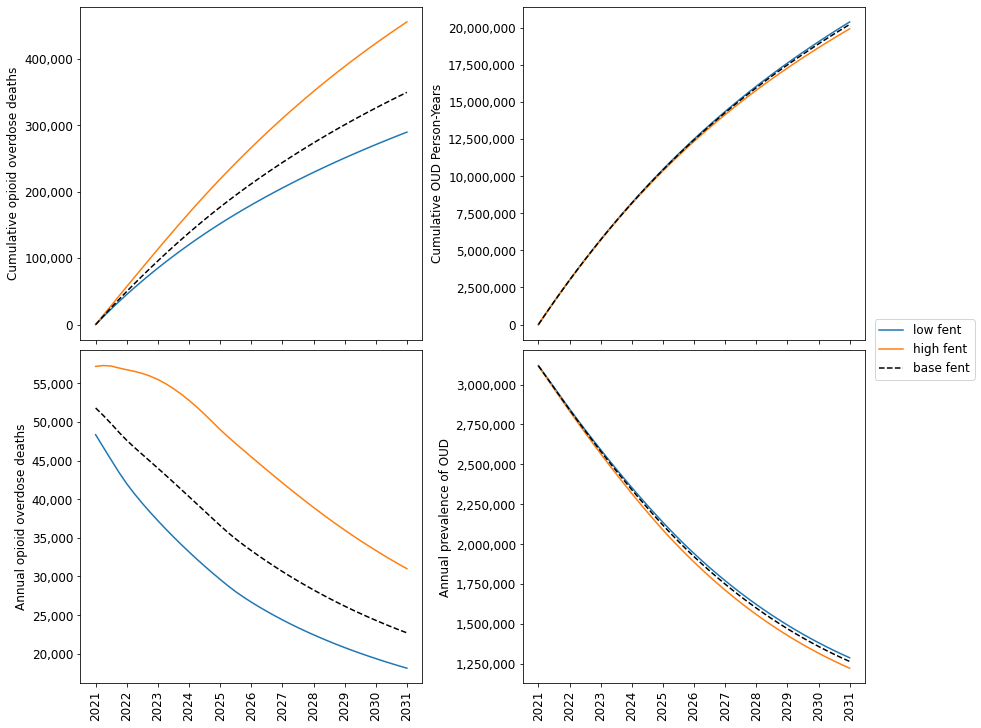

In [9]:
## PLOT CUMULATIVE FENTANYL GRAPHS ##
outcomes = ['Cumulative opioid overdose deaths', 'Cumulative OUD Person-Years',
        'Annual opioid overdose deaths', 'Annual prevalence of OUD']
fent = ['low fent', 'high fent', 'base fent']

lofent = pd.read_csv(f'X3_FentL_PolRes.tab', sep='\t', index_col=[1, 0])
hifent = pd.read_csv(f'X3_FentH_PolRes.tab', sep='\t', index_col=[1, 0])
basefent = pd.read_csv(f'X3_Base_PolRes.tab', sep='\t', index_col=[1, 0])

display(basefent)

lf = lofent.loc['Baseline'].loc['Projected cumulative UD person years':'Projected total with UD']
hf = hifent.loc['Baseline'].loc['Projected cumulative UD person years':'Projected total with UD']
bf = basefent.loc['Baseline'].loc['Projected cumulative UD person years':'Projected total with UD']

allf = pd.concat([lf, hf, bf], keys = ['low fent', 'high fent', 'base fent']).swaplevel(i=0, j=1, axis=0)

allf.rename(index={'Projected cumulative overdose deaths':'Cumulative opioid overdose deaths',
                   'Projected cumulative UD person years': 'Cumulative OUD Person-Years',
                   'Projected total overdose deaths':'Annual opioid overdose deaths',
                   'Projected total with UD':'Annual prevalence of OUD'
                  }, inplace=True)
allf.index.set_names('Fentanyl Level', level=1, inplace=True)


formats = pd.DataFrame({"color":['tab:blue', 'tab:orange', 'k'],
                       "linetype":['-', '-', '--']},
                     index = ['low fent', 'high fent', 'base fent'])

fig4, axs = plt.subplots(2, 2, figsize=[12, 10], sharex=True, constrained_layout=True) 

for ax, var in zip(axs.flatten(), outcomes):
    s = allf.loc[var]
    for scen in fent:
        linecolor = formats.loc[scen, 'color']
        linetype = formats.loc[scen, 'linetype']
        ax.plot(s.loc[scen], c=linecolor, linestyle=linetype, label=scen)
        loc = mticker.MultipleLocator(base=4)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelrotation=90)
        ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_ylabel(str(var))
fig4.legend(['low fent', 'high fent', 'base fent'], loc='center right', bbox_to_anchor = (1.13, 0.52))
fig4.savefig(f'Figures/fentscenarios.svg', bbox_inches='tight')

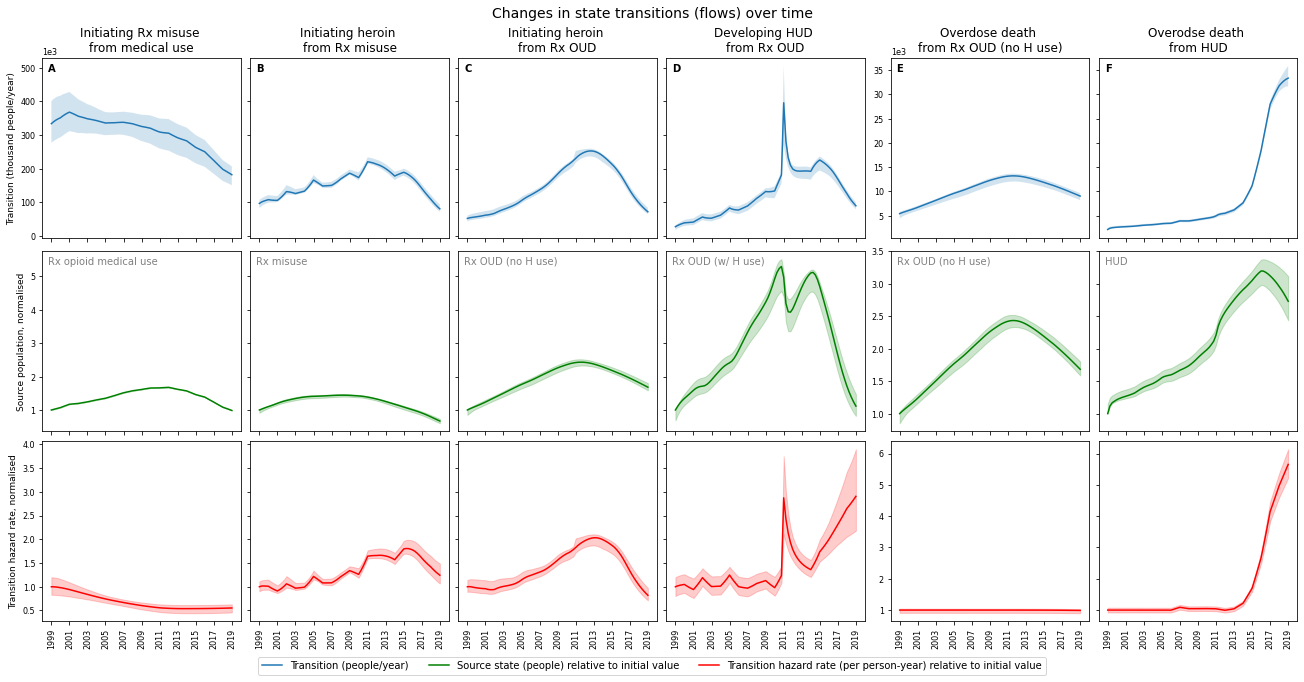

In [48]:
##### PLOT RATE-STOCK-HAZARD GRAPHS #####

# Read in main and sensitivity results and truncate to just historical portion
t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
t = t.loc[:, :f'{endyear}']
s = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])
s = s.loc[:, :f'{float(endyear)}']

# Establish list of rates-stocks-hazards-titles-stocknames to plot
rateslist = [
    ['Initiating Rx misuse own Rx', 'Patients with current opioid Rx', 
     'Initiation rate Rx misuse own Rx effective', 'Initiating Rx misuse \nfrom medical use', 
     'Rx opioid medical use'], 
    ['Initiating heroin with Rx misuse', 'Rx misuse no PY heroin', 
     'Initiation rate heroin with Rx misuse effective', 'Initiating heroin \nfrom Rx misuse', 
     'Rx misuse'], 
    ['Initiating heroin with Rx OUD', 'Rx OUD no PY heroin no MOUD', 
     'Initiation rate heroin with Rx OUD effective', 'Initiating heroin \nfrom Rx OUD', 
     'Rx OUD (no H use)'], 
    ['Developing HUD with Rx OUD', 'Rx OUD with PY heroin no MOUD', 
     'Developing HUD rate with Rx OUD effective', 'Developing HUD \nfrom Rx OUD', 
     'Rx OUD (w/ H use)'], 
    ['Overdose death Rx OUD no H', 'Rx OUD no PY heroin no MOUD', 
     'Overdose death rate Rx OUD no H', 'Overdose death \nfrom Rx OUD (no H use)', 
     'Rx OUD (no H use)'], 
    ['Overdose death HUD', 'HUD no MOUD', 
     'Overdose death rate HUD', 'Overodse death \nfrom HUD', 'HUD']
]

# Define y-axis labels
ylabels = ['Transition (thousand people/year)', 
           'Source population, normalised', 
           'Transition hazard rate, normalised']

# Set up main figure with three rows of axes
fig0, axs = plt.subplots(3, 6, figsize=[18, 9], sharex=True, constrained_layout=True)

# Set up sub-lists of axes for rows and columns
row0, row1, row2 = axs
col_list = [col for col in zip(row0, row1, row2)]

# Set up y-axis sharing 
for row in axs:
    for ax in row[1:4]:
        ax.sharey(row[0])
        ax.tick_params(labelleft=False)
    
    row[4].sharey(row[5])
    row[5].tick_params(labelleft=False)

# Add panel labels to top row for each column
for ax, label in zip(row0, ['A', 'B', 'C', 'D', 'E', 'F']):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontweight='bold', va='top')

# Iterate through columns/rates and plot lines and credible regions on each 
for rate, col in zip(rateslist, col_list):
    axa, axb, axc = col # Unpack column to three separate axes
    
    line0, = axa.plot(t.loc[rate[0]])
    line1, = axb.plot(t.loc[rate[1]]/t.loc[rate[1], f'{styear}'], color='g')
    line2, = axc.plot(t.loc[rate[2]]/t.loc[rate[2], f'{styear}'], color='r')
    for bd in bounds:
        axa.fill_between(t.columns, s.loc[rate[0], bd[0]], s.loc[rate[0], bd[1]], alpha=0.2)
        axb.fill_between(t.columns, s.loc[rate[1], bd[0]]/t.loc[rate[1], f'{styear}'], 
                         s.loc[rate[1], bd[1]]/t.loc[rate[1], f'{styear}'], alpha=0.2, color='g')
        axc.fill_between(t.columns, s.loc[rate[2], bd[0]]/t.loc[rate[2], f'{styear}'], 
                         s.loc[rate[2], bd[1]]/t.loc[rate[2], f'{styear}'], alpha=0.2, color='r')

    # Add stocknames from rateslist as labels to second row
    axb.text(0.03, 0.97, rate[4], transform=axb.transAxes, color='gray', va='top')
    
    # Set up axis labels & title
    loc = mticker.MultipleLocator(base=8)
    axc.xaxis.set_major_locator(loc)
    axc.tick_params(axis='x', labelsize=8, labelrotation=90)
    for ax in col:
        ax.tick_params(axis='y', labelsize=8)
    axa.set_title(rate[3]) # Take title from rateslist

# Format y-axis and set labels
for ax in row0:
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.offsetText.set_fontsize(8)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

for row, label in zip(axs, ylabels):
    row[0].set_ylabel(label, fontsize=9) # Put label only on leftmost axes

fig0.suptitle('Changes in state transitions (flows) over time', fontsize=14)

# Set up and display legend
handles = [line0, line1, line2]
labels = ['Transition (people/year)', 'Source population (people) relative to initial value', 
          'Transition hazard rate (per person-year) relative to initial value']
fig0.legend(handles, labels, loc=9, bbox_to_anchor=(0.5, 0), ncol=3)

fig0.savefig(f"./{baserunname}_rates_3row.jpg", bbox_inches='tight')

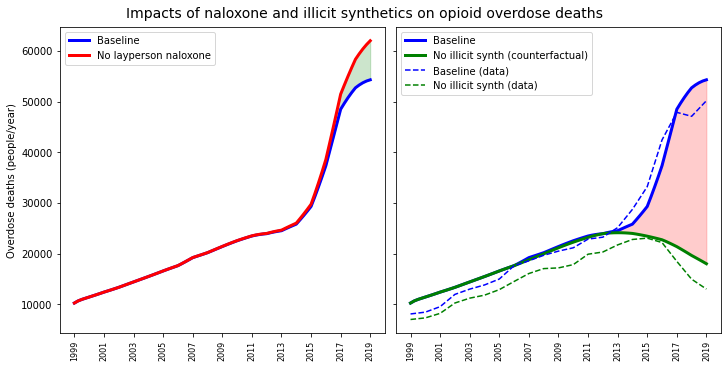

In [71]:
##### PLOT FENTANYL AND NALOXONE COUNTERFACTUALS GRAPHS #####

# Read in base and no-fentanyl scenario results and truncate to just historical portion
table = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
nft = pd.read_csv(f'{baserunname}_final_{scenariolist[0][:-4]}_vars.tab', sep='\t', index_col=0)
table = table.loc[:, :f'{endyear}']
nft = nft.loc[:, :f'{endyear}']

# Compile separate dataframe of just relevant results
baseod = table.loc['Total overdose deaths']
nxodav = (table.loc['Nx utilization deaths averted Rx user'] 
          + table.loc['Nx utilization deaths averted H user'])
nofent = nft.loc['Total overdose deaths']
nfdata = (table.loc['Total overdose deaths base Rx NVSS'] 
          + table.loc['Total overdose deaths base heroin NVSS'])
nfnxav = (nft.loc['Nx utilization deaths averted Rx user'] 
          + nft.loc['Nx utilization deaths averted H user'])
oddata = table.loc['Total overdose deaths NVSS']

odcomp = pd.concat([baseod, nxodav, nofent, nfdata, nfnxav, oddata], 
                   keys=['Base', 'NxDA', 'NoFent', 'NFData', 'NFNxDA', 'ODData'], axis=1)

del table, nft # Clear large dataframes to free up memory

# Calculate sums to stack graphs
odcomp['NoNx'] = odcomp['Base'] + odcomp['NxDA']
odcomp['NFNoNx'] = odcomp['NoFent'] + odcomp['NFNxDA']

# Interpolate data to allow complete line plotting
odcomp['NFData'] = odcomp['NFData'].interpolate()
odcomp['ODData'] = odcomp['ODData'].interpolate()

# Set up two-axes figure
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 5], sharey=True, constrained_layout=True)

# Plot naloxone results on first axes
base = ax0.plot(odcomp['Base'], color='b', lw=3, label='Baseline')
nonx = ax0.plot(odcomp['NoNx'], color='r', lw=3, label='No layperson naloxone')
ax0.fill_between(odcomp.index, odcomp['Base'], odcomp['NoNx'], color='g', alpha=0.2)
ax0.legend()

# Plot fentanyl results and data on second axes
base2 = ax1.plot(odcomp['Base'], color='b', lw=3, label='Baseline')
nfnt = ax1.plot(odcomp['NoFent'], color='g', lw=3, label='No illicit synth (counterfactual)')
ax1.fill_between(odcomp.index, odcomp['Base'], odcomp['NoFent'], color='r', alpha=0.2)
based = ax1.plot(odcomp['ODData'], ls='dashed', color='b', label='Baseline (data)')
nfntd = ax1.plot(odcomp['NFData'], ls='dashed', color='g', label='No illicit synth (data)')
ax1.legend()

loc = mticker.MultipleLocator(base=8)
for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(axis='x', labelsize=8, labelrotation=90)
    
# Set labels for left-hand axes only, and figure title
ax0.set_ylabel('Overdose deaths (people/year)')
fig0.suptitle('Impacts of naloxone and illicit synthetics on opioid overdose deaths', fontsize=14)

fig0.savefig(f"./{baserunname}_fentnxod.jpg", bbox_inches='tight')

In [ ]:
##### PLOT ALL VARS FIT TO DATA & PROJECTIONS #####

def plot_fits_full(table, fullfits, fitdict):
    """Plot fit-to-data for all variables specified in `fullfits` list, 
    with names from `fitdict`"""
    
    # Define main figure and axes
    fig0, axs = plt.subplots(4, 4, figsize=[14, 10], sharex=True, constrained_layout=True)

    # Plot sim output and data
    for var, ax in zip(fullfits, axs.flatten()):
        ax.plot(table.loc[f'SimVar[{var}]'])
        ax.scatter(table.columns[::4], table.loc[f'DataVar[{var}]'][::4], color='silver')
        ax.set_title(fitdict[var], fontsize=9)

        # Format X and Y axis for all axes
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=7, labelrotation=90)

        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
        ax.yaxis.offsetText.set_fontsize(7)
        ax.tick_params(axis='y', labelsize=7)
    
    return fig0


def plot_fits_proj_full(table, senstable, fullfits, fitdict, 
                        bounds, basevar='SimVar', noisevar=None, endyear='2019'):
    """Plot projections for all variables specified in `fullfits` list, 
    with CrIs specified in `bounds` (multiple CrIs allowed, use paired 
    lower/upper values) and names from `fitdict`; show CrIs without 
    noise by default; show CrIs with noise if `noisevar` specified 
    (usually as RepVar)"""
    t, s = table, senstable # For more compact code
    
    # Define main figure and axes
    fig0, axs = plt.subplots(4, 4, figsize=[14, 10], sharex=True, constrained_layout=True)
    
    # Plot sim output and CI bounds
    for ax, var in zip(axs.flatten(), fullfits):
        ax.plot(t.columns, t.loc[f'{basevar}[{var}]'])
        for bd in bounds:
            if noisevar: # Additionally show CIs for noise if specified
                ax.fill_between(t.columns, s.loc[f'{noisevar}[{var}]', bd[0]], 
                                s.loc[f'{noisevar}[{var}]', bd[1]], alpha=0.2, color='grey')
            ax.fill_between(t.columns, s.loc[f'{basevar}[{var}]', bd[0]], 
                            s.loc[f'{basevar}[{var}]', bd[1]], alpha=0.2)
        ax.set_title(fitdict[var], fontsize=9)
        
        # Add vertical dashed line to mark end of data
        ax.vlines(endyear, 0, 1, transform=ax.get_xaxis_transform(), color='r', ls='dashed')
        
        # Format X and Y axis for all axes
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=7, labelrotation=90)

        ax.set_ylim(0) # Anchor y axis on 0
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))
        ax.yaxis.offsetText.set_fontsize(7)
        ax.tick_params(axis='y', labelsize=7)

    return fig0


# Specify all vars to be included
fullfits = ['InRM', 'InRD', 'RMis', 'NDHU', 'ROUD', 'ROUH', 'HUD', 'TxBp', 
            'InHD', 'InHR', 'InHO', 'InHT', 'ODRB', 'ODSB', 'ODHC', 'ODTo']

# Read in and plot fits to data
table = pd.read_csv(f'{baserunname}_fits.tab', sep='\t', index_col=0)
fig0 = plot_fits_full(table, fullfits, fitdict)
fig0.savefig(f"./{baserunname}_fits_full.jpg", bbox_inches='tight')

# Read in main and sensitivity results to plot all vars projections for each base scenario
for scen in basescens:
    t = pd.read_csv(f'{baserunname}_final_{scen[:-4]}_vars.tab', sep='\t', index_col=0)
    s = pd.read_csv(f'{baserunname}_sens_{scen[:-4]}_clean.tab', sep='\t', index_col=[0,1])

    fig1 = plot_fits_proj_full(t, s, fullfits, fitdict, bounds, endyear=str(endyear))
    fig1.savefig(f"./{baserunname}_fits_proj_full_{scen[:-4]}.jpg", bbox_inches='tight')


In [ ]:
##### SYNDATA INTERVALS GRAPH AND PARAM ESTIMATES MEGA-PLOT #####

def plot_syndata_intervals(means, percs):
    """Plot percent of syndata estimates within each theoretical CrI"""
    spmdf = means.iloc[0:len(percs)] * 100 # Select relevant rows of means df
    spmdf.loc[0] = 0 # Anchor results on (0,0)
    spmdf.sort_index(inplace=True)
    
    # Create figure, then plot and label results
    fig0, ax0 = plt.subplots(figsize=[7,6.5], constrained_layout=True)

    ax0.plot(spmdf)
    ax0.scatter(spmdf.index, spmdf.values, marker='s')
    ax0.plot([0,100], [0,100], ls='dashed') # Plot 1:1 line

    ax0.set_xlabel('Theoretical credible interval (percent)')
    ax0.set_ylabel('Estimated parameters inside CI (percent)')
    fig0.suptitle('Synthetic data estimation credible interval accuracy', fontsize=14)
    
    return fig0


def plot_syndata_params(syndf, synpercdf, perc):
    """Plot parameter estimates, CIs, and true values for syndata output 
    for all params and syndata runs in single mega-plot"""
    varnum = len(syndf.columns) # Get number of vars to plot

    # Create figure laying out axes in rows of three
    fig0, axs = plt.subplots(int(np.ceil(varnum/3)), 3, 
                             figsize=[12, np.ceil(varnum/3) * 1.5], constrained_layout=True)

    # Delete any excess axes
    for i in range(len(axs.flatten())-varnum):
        fig0.delaxes(axs.flatten()[varnum + i])

    # Iterate over axes & vars to plot each one
    for ax, var in zip(axs.flatten(), syndf.columns):
        s = syndf[var]

        bds = strbds_from_perc(perc) # Get bounds for errorbars from specified interval
        errs = ((s['0.5'] - s[bds[0]]), s[bds[1]] - s['0.5'])

        # Plot estimated value with CI and true value
        ax.errorbar(s['Value'].index, s['Value'].values, yerr=errs, fmt='o', capsize=3)
        ax.scatter(s['True'].index, s['True'].values, marker='x', color='r', s=9**2)
        
        # Set title including % values within bounds
        ax.set_title(f'{var} ({synpercdf[var].loc[perc].mean()})', fontsize=9)

        # Format x and y axis
        loc = mticker.MultipleLocator(base=1)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_ticklabels([])

        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
        ax.yaxis.offsetText.set_fontsize(7)
        ax.tick_params(axis='y', labelsize=7)
    
    return fig0


# Plot theoretical CrI vs. actual included values comparison
means = pd.read_csv(f'{baserunname}_syndata_means.tab', sep='\t', index_col=0)
fig0 = plot_syndata_intervals(means, percs)
fig0.savefig(f"./{baserunname}_syn_intervals.jpg", bbox_inches='tight')

# Plot syndata param estimates and true values, breaking up mega-plot to fit on separate pages
syndf = pd.read_csv(f'{baserunname}_syndata_results.tab', sep='\t', index_col=[0, 1])
syndf = syndf.reorder_levels(['Perc', 'Run']).sort_index()

fig0 = plot_syndata_params(syndf.iloc[:, 0:33], synpercdf.iloc[:, 0:33], syn_mainperc)
fig0.savefig(f'./{baserunname}_syn_params_0.jpg', bbox_inches='tight')
fig1 = plot_syndata_params(syndf.iloc[:, 33:66], synpercdf.iloc[:, 33:66], syn_mainperc)
fig1.savefig(f'./{baserunname}_syn_params_1.jpg', bbox_inches='tight')
fig2 = plot_syndata_params(syndf.iloc[:, 66:], synpercdf.iloc[:, 66:], syn_mainperc)
fig2.savefig(f'./{baserunname}_syn_params_2.jpg', bbox_inches='tight')

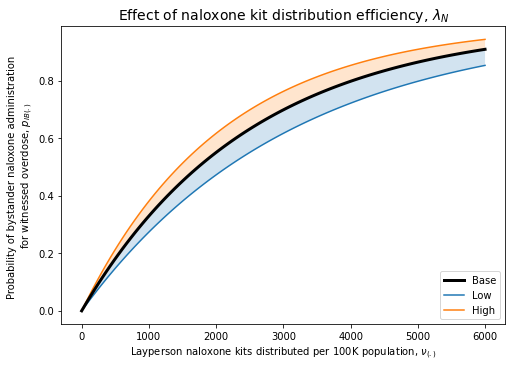

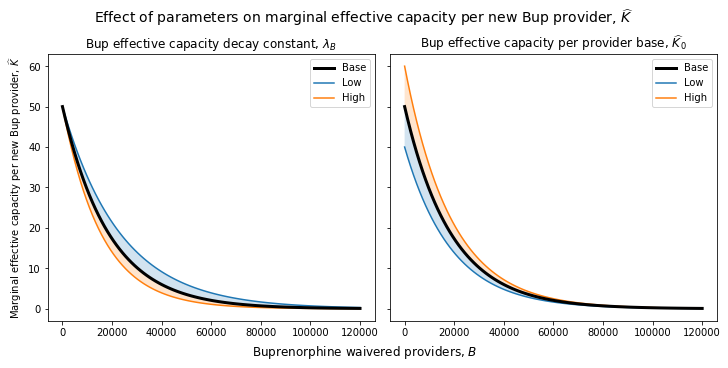

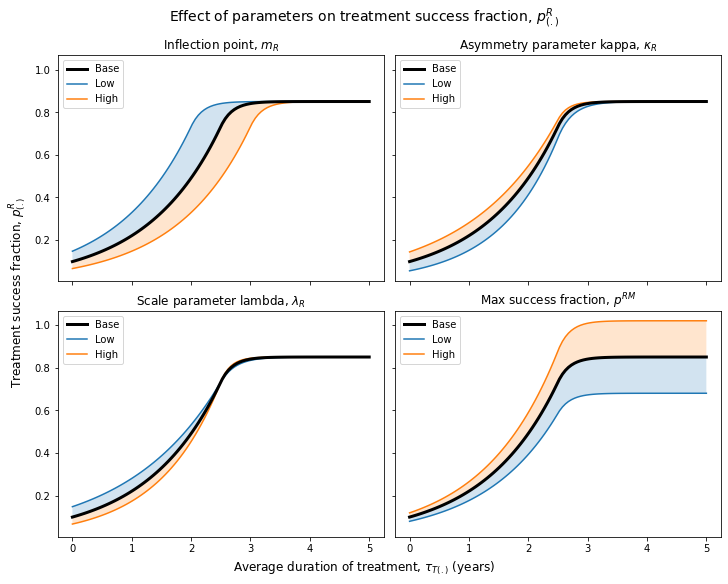

In [64]:
##### ANALYTICAL FUNCTION GRAPHING SHOWING PARAMETER SENSITIVITY #####

def prob_nx(x, k):
    return 1 - np.exp(-k * x)

def bup_cap_avg(x, k, b):
    return (b * np.exp(-k * x) / -k + b/k)/x

def bup_cap_marginal(x, k, b):
    return b * np.exp(-k * x)

def tx_success(x, i, k, l, m):
    y = np.where(x < i, 
                 k ** 2 / (1 + k ** 2) * np.exp((l / k * (x - i))), 
                 1 - np.exp(-l * k * (x - i)) / (1 + k ** 2)) * m
    return y


def eval_func(func, xrng, args, sensrange=0.2):
    """Umbrella function for calculating results of `func` with `args` 
    over range `xrng`, varying each arg over +/- `sensrange` values"""
    x = np.linspace(*xrng, 100)
    y = []
    for i in range(len(args)):
        args_l = args.copy()
        args_l[i] = args[i] * (1 - sensrange)
        args_h = args.copy()
        args_h[i] = args[i] * (1 + sensrange)
        y.append((func(x, *args), func(x, *args_l), func(x, *args_h)))
    return x, y

def plot_func(x, y, axs):
    """Plot function output from `eval_func`, with +/- arg values"""
    for (m, l, h), ax in zip(y, axs):
        ax.plot(x, m, c='k', lw=3, zorder=10, label='Base')
        ax.plot(x, l, label='Low')
        ax.fill_between(x, m, l, alpha=0.2)
        ax.plot(x, h, label='High')
        ax.fill_between(x, m, h, alpha=0.2)


# Set mdl and out filenames from which to read parameter values
mdl = mdl = f'../{simsettings['model']}'
out = f'../{baserunname}_main_full.out'

# Evaluate and plot Nx distribution efficiency function
k = get_value(out, 'Nx kit distribution efficiency')
x, y = eval_func(prob_nx, [0, 6000], k)
fig0, ax0 = plt.subplots(figsize=[7, 5], constrained_layout=True)
axs = [ax0] # plot_func reads in axs as list
plot_func(x, y, axs)
ax0.set_xlabel(r'Layperson naloxone kits distributed per 100K population, $\nu_{(.)}$')
ax0.set_ylabel('Probability of bystander naloxone administration \n' 
               + r'for witnessed overdose, $p_{IB(.)}$')
ax0.set_title(r'Effect of naloxone kit distribution efficiency, $\lambda_N$', fontsize=14)
ax0.legend(loc=4)
fig0.savefig(f"./Function_ProbNx.jpg", bbox_inches='tight')

# Evaluate and plot marginal bup cap per provider function
k = get_value(mdl, 'Bup effective capacity decay constant')
b = get_value(mdl, 'Bup effective capacity per provider base')
x, y = eval_func(bup_cap_marginal, [0, 120000], [k, b])
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 5], sharey=True, constrained_layout=True)
axs = [ax0, ax1]
plot_func(x, y, axs)
fig0.supxlabel(r'Buprenorphine waivered providers, $B$')
fig0.suptitle(r'Effect of parameters on marginal effective capacity per new Bup provider, '
              r'$\widehatK$', fontsize=14)
ax0.set_ylabel(r'Marginal effective capacity per new Bup provider, $\widehatK$')
ax0.set_title(r'Bup effective capacity decay constant, $\lambda_B$')
ax1.set_title(r'Bup effective capacity per provider base, $\widehatK_0$')
ax0.legend()
ax1.legend()
fig0.savefig(f"./Function_BupCap.jpg", bbox_inches='tight')

# Evaluate and plot Tx duration-success function
i, k, l, m = [get_value(mdl, f'Tx success fraction {var}') 
              for var in ['inflection', 'kappa', 'lambda', 'max']]
x, y = eval_func(tx_success, [0, 5], [i, k, l, m])
fig0, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=[10, 8], sharex=True, sharey=True, 
                                              constrained_layout=True)
axs = [ax0, ax1, ax2, ax3]
plot_func(x, y, axs)
fig0.supxlabel(r'Average duration of treatment, $\tau_{T(.)}$ (years)')
fig0.supylabel(r'Treatment success fraction, $p^R_{(.)}$')
fig0.suptitle(r'Effect of parameters on treatment success fraction, $p^R_{(.)}$', fontsize=14)
ax0.set_title(r'Inflection point, $m_R$')
ax1.set_title(r'Asymmetry parameter kappa, $\kappa_R$')
ax2.set_title(r'Scale parameter lambda, $\lambda_R$')
ax3.set_title(r'Max success fraction, $p^{RM}$')
for ax in axs:
    ax.legend()
fig0.savefig(f"./Function_TxSF.jpg", bbox_inches='tight')

# Evaluate and plot bup patients per provider function and data
# Read in and subset necessary data
t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
t = t.loc[:, :f'{endyear}']
prov = t.loc['Bup providers DATA']
pats = t.loc['Tx annual patients Bup IQVIA TPT']
pppr = t.loc['Bup patients per provider DATA']
pppn = t.loc['Bup effective capacity per provider net']

# Evaluate and plot average bup cap function and patients per provider data
k = get_value(mdl, 'Bup effective capacity decay constant')
b = get_value(mdl, 'Bup effective capacity per provider base')
x, y = eval_func(bup_cap_avg, [0, 75000], [k, b])
fig0, ax0 = plt.subplots(figsize=[8,6], constrained_layout=True)
ax0.plot(x, y[0][0], label='Avg. effective capacity per provider (indicated)')

# Add line for net capacity per provider
ax0.plot(prov.interpolate(), pppn, label='Avg. effective capacity per provider (net)')

# Add and label historical patients per provider datapoints
ax0.scatter(prov, pppr, marker='x', color='r', label='Patients per provider (data)')
for i in t.columns[12:]:
    ax0.annotate(i, (prov[i], pppr[i]), xytext=(-10, 5), textcoords='offset points', fontsize=8)

ax0.set_xlabel(r'Buprenorphine waivered providers, $B$')
ax0.set_ylim(ymax=37) # Limit Y axis to reduce compactness of graph
ax0.set_ylabel(r'Patients per provider, $K_B/B$')
fig0.suptitle(r'Calculated vs. observed avg. patients or capacity per provider, $K_B/B$', 
              fontsize=14)
ax0.legend()
del t
fig0.savefig(f"./Function_BupData.jpg", bbox_inches='tight')


In [ ]:
##### HORIZONTAL FIT-TO-DATA & PROJECTIONS PLOTS #####

def plot_fits_main_horizontal(fits, mainfits, fitdict, ylabels, errmult=1.96):
    """Plot horizontal version of `plot_fits_main` with minor graphical 
    changes, for use in presentations"""
    
    # Define main figure and axes
    fig0, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(
        2, 3, figsize=[16, 7], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax3, ax1, ax4, ax2, ax5]

    for ax, var in zip(ax_list, mainfits):
        ax.plot(fits.columns, fits.loc[f'SimVar[{var}]'], lw=3, 
                color='#007CBA', zorder=10, label='Simulated') # Use FDA blue for lines
        ax.scatter(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
                   color='dimgrey', label='Historical')
        try:
            ax.errorbar(fits.columns[::4], fits.loc[f'DataVar[{var}]'][::4], 
                        yerr=fits.loc[f'DataErr[{var}]'][::4] * errmult, fmt='o', 
                        color='dimgrey', capsize=3, label='Historical')
        except KeyError: # Catch exception when DataErr not available
            pass
        
        # Format X and Y axis for all axes
        ax.set_ylim(0) # Anchor y axis on 0
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
        
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8)
        
    # Set labels for top row in lower left, bottom row in upper left
    for ax, label, var in zip([ax0, ax1, ax2], ylabels, mainfits[::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.05, fitdict[var], transform=ax.transAxes, fontsize=14, va='bottom')
    
    for ax, label, var in zip([ax3, ax4, ax5], ylabels, mainfits[1::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.95, fitdict[var], transform=ax.transAxes, fontsize=14, va='top')
        
    for ax in [ax2, ax5]:
        # Format Y-axis ticks without scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
        
    fig0.savefig(f"./{baserunname}_fits_main_horizontal.jpg", bbox_inches='tight')


def plot_fits_proj_horizontal(table, senstable, projfits, fitdict, bounds, 
                              ylabels, basevar='SimVar', endyear='2019'):
    """Plot horizontal version of `plot_fits_proj_scens` with single 
    scenario only, for use in presentations"""
    t, s = table, senstable # For more compact code
    
    # Define main figure and axes
    fig0, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(
        2, 3, figsize=[16, 7], sharex=True, constrained_layout=True)
    ax_list = [ax0, ax3, ax1, ax4, ax2, ax5]

    # Plot sim output and CrI bounds
    for ax, var in zip(ax_list, projfits):
        ax.plot(t.columns, t.loc[f'{basevar}[{var}]'], color='#007CBA') # Use FDA blue for lines

        for bd in bounds:
            ax.fill_between(t.columns, s.loc[f'{basevar}[{var}]', bd[0]], 
                            s.loc[f'{basevar}[{var}]', bd[1]], color='#007CBA', alpha=0.2)
        
        # Add vertical dashed line to mark end of data
        ax.vlines(endyear, 0, 1, transform=ax.get_xaxis_transform(), color='r', ls='dashed')
        
        # Format X and Y axis for all axes
        ax.set_ylim(0) # Anchor y axis on 0
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
        
        loc = mticker.MultipleLocator(base=8)
        ax.xaxis.set_major_locator(loc)
        ax.tick_params(axis='x', labelsize=8, labelrotation=90)

    # Set labels for top row in lower left, bottom row in upper left
    for ax, label, var in zip([ax0, ax1, ax2], ylabels, projfits[::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.05, fitdict[var], transform=ax.transAxes, fontsize=14, va='bottom')
    
    for ax, label, var in zip([ax3, ax4, ax5], ylabels, projfits[1::2]):
        ax.set_ylabel(label)
        ax.text(0.05, 0.95, fitdict[var], transform=ax.transAxes, fontsize=14, va='top')
        
    for ax in [ax2, ax5]:
        # Format Y-axis ticks without scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    
    fig0.savefig(f"./{baserunname}_fits_proj_horizontal.jpg", bbox_inches='tight')


# Add display labels to fitdict
fitdict['ODRT'] = 'Overdose deaths \n(Rx & Rx synthetics)'    
fitdict['ODHC'] = 'Overdose deaths (heroin \n& illicit synthetics)'

# Read in data to plot and subset as necessary
fits = pd.read_csv(f'{baserunname}_fits.tab', sep='\t', index_col=0)
fits = fits.loc[:, :f'{endyear}']
t = pd.read_csv(f'{baserunname}_final_{basescens[0][:-4]}_vars.tab', sep='\t', index_col=0)
s = pd.read_csv(f'{baserunname}_sens_{basescens[0][:-4]}_clean.tab', sep='\t', index_col=[0,1])

# Create plots with grayed out axes for better visual contrast
with plt.rc_context({'axes.edgecolor':'gray', 'xtick.color':'gray', 
                     'ytick.color':'gray', 'axes.labelcolor':'gray'}):
    plot_fits_main_horizontal(fits, mainfits, fitdict, fits_y_labels)
    plot_fits_proj_horizontal(t, s, projfits, fitdict, bounds, fits_y_labels, endyear=str(endyear))

In [ ]:
##### SEND MAIN OUTPUTS TO SUBFOLDER FOR EASY ACCESS #####

os.chdir(basedir)
os.chdir('./Results')
os.makedirs('./ResMain', exist_ok=True)

resmain = ['assm_sens.tab', 'GOF.tab', 'inputs.tab', 'lk_sens.tab', 'params.tab', 
           'polproj.tab', 'proj_changes.tab', 'syndata_means.tab', 'yearvals.tab', 
           'summary.txt']

for res in resmain:
    copy(f'./{baserunname}_{res}', './ResMain')
